In [1]:
%pylab inline
from jk_utils import *
from astropy.cosmology import Planck15 
import astropy.units as u
import seaborn as sns
import colorsys
import matplotlib.colors as mc
from scipy.optimize import minimize
import seaborn as sns
import colorsys
import matplotlib.colors as mc
from power_spectra import *
from hankel_transform import *
from wigner_transform import *
colors=sns.color_palette()
markers=['o','^','>','<','v','s']

Populating the interactive namespace from numpy and matplotlib


In [2]:
cosmo=Planck15.clone()#we want h=1 for some comparisons
cosmo_h=Planck15.clone(H0=100)#we want h=1 for some comparisons


In [3]:
#set parameters for power spectra computations.
#play around with kmax,kmin to find optimal values for your case (based on rmin,rmax). 
#Remember very high kmax or very low kmin will require finer grid, slowing down the initial setup of the hankel transform. 
#Subsequent calculations of correlation functions are fast, so speed should not be major issue when running fits.
#need atleast k=10 and k=1.e-3 to get decent wgg for 1-100 Mpc/h range.
kmax=30
kmin=.8e-3
k_smooth=1
nk=5000
rmin=0.1
rmax=100
non_linear=1


# r_bins=np.logspace(-1,np.log10(100),21) #np.logspace(0,2,11)

cosmo_fid=dict({'h':cosmo.h,'Omb':cosmo.Ob0,'Omd':cosmo.Om0-cosmo.Ob0,'s8':0.817,'Om':cosmo.Om0,
                'As':2.12e-09,'mnu':cosmo.m_nu[-1].value,'Omk':cosmo.Ok0,'tau':0.06,'ns':0.965,'w':-1,'wa':0})
pk_params={'non_linear':non_linear,'kmax':kmax,'kmin':kmin,'nk':nk}

#Setting up the Hankel Transform
#This part is slower. But only needs to be run once. 
#If you only need wgg, set j_nu=[0]. For wg+ (or \Delta\Sigma) use j_nu=[2]
%time HT=hankel_transform(rmin=rmin,rmax=rmax,kmax=kmax,j_nu=[0,2],n_zeros=28000,kmin=kmin)

j-nu= 0  not enough zeros to cover kmin, increasing by  1000  to 29000
nr: 956
changed kmax to 51.35622301840682  to cover rmin
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 29000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 30000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 31000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 32000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 33000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 34000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 35000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 36000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 37000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 38000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 39000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 40000
j-nu= 2  not enough 

In [4]:
r_bins=np.logspace(-4,np.log10(80),26) #FIXME: put correct binning
r_bins=r_bins[r_bins>0.1]

In [5]:
C1_rhoC=0.0134
Om=cosmo.Om0

L_W=100 #length of box (line of sight)
area_comoving=L_W**2
vol=area_comoving*L_W


In [6]:
PS=Power_Spectra(cosmo_params=cosmo_fid,pk_params=pk_params)

In [8]:
z_mean=0.06

In [9]:
chi=cosmo_h.comoving_transverse_distance(z=z_mean).value
ell=np.unique(np.int32(HT.k[2]*chi))
theta=HT.r[2]/chi
WT_kwargs={'l': ell,'theta': theta,'s1_s2':[(0,2),(2,0),(0,0)]} #(2,2),(2,-2)
WT=wigner_transform(**WT_kwargs)

Dz=PS.DZ_int(z=np.append([0],z_mean),cosmo=cosmo)# Dz is normalized to 1 at lowest z. 
                                        #Hence appending 0 in front to get Dz normalized to 1 at z=0
Dz=Dz[1]/Dz[0]

/home/deep/data/repos/Public-code/Hankel_transform/wigner_functions.py:46: RuntimeWarning: divide by zero encountered in true_divide
  d_mat/=np.sqrt(binom(k+b,b))
/home/deep/data/repos/Public-code/Hankel_transform/wigner_functions.py:46: RuntimeWarning: divide by zero encountered in true_divide
  d_mat/=np.sqrt(binom(k+b,b))


In [50]:
wgp_f=C1_rhoC*Om/Dz

In [51]:
wgp_f

0.004252105494727195

In [10]:
fig_home='./figures/'
fig_format='pdf'

In [11]:
labels={}
labels['ia']='$w_{g+}$ [Mpc/h]'
labels['gg']='$w_{gg}$ [Mpc/h]'



In [12]:
njk=8

In [133]:
def write_dat_nojk(home='',home_gg='',dataset='',njk=0,out_name='',analytical_cov_args={}): #FIXME: analytical_cov_args is a dict with args of analytical_cov function
    data_jk=np.genfromtxt(home+'wgp_jk_'+dataset+'.txt')
    
    wgg_jk=np.genfromtxt(home_gg+'wgg_jk.txt')#wgg same for all
    
    rp=np.genfromtxt(home+'rp_1tidal_0.txt')
    
    cov_args=np.genfromtxt(home+'sim_cov_args_'+dataset+'.txt')#,names=( 'Ngal_shape', 'Ngal_density', 'sigma_gamma'))
    i=0
    for c in [ 'Ngal_shape', 'Ngal_density', 'sigma_gamma']:
        analytical_cov_args[c]=cov_args[i]
        i+=1
    if 'tidal_1' in dataset:
        analytical_cov_args['sigma_gamma']*=wgp_f
        data_jk*=wgp_f
    x=rp>0.1
    rp=rp[x]
    data_jk=data_jk[:,x]
    wgg_jk=wgg_jk[:,x]
    
    cov_gp=np.cov(data_jk,rowvar=0)
    cov_gp*=(njk-1.)*(njk-1.)/njk
    err=np.sqrt(np.diag(cov_gp))
    corr_gp=cov_gp/np.outer(err,err)
    
    cov_gg=np.cov(wgg_jk,rowvar=0)
    cov_gg*=(njk-1.)*(njk-1.)/njk
    err_gg=np.sqrt(np.diag(cov_gg))
    corr_gg=cov_gg/np.outer(err_gg,err_gg)
    
    cov_gp_ana,err_ana,cov_gg_ana,err_gg_ana=analytical_cov(**analytical_cov_args)
    corr_gp_ana=cov_gp_ana/np.outer(err_ana,err_ana)
    corr_gg_ana=cov_gg_ana/np.outer(err_ana,err_ana)
    
    dat_out=np.column_stack((rp,data_jk.mean(axis=0),err_ana,wgg_jk.mean(axis=0),err_gg_ana))
#     print(dat_out,cov_gp.shape)
    s='rp wgp wgp_err wgg wgg_err'
    np.savetxt(out_name+'.dat',dat_out,header=s,fmt='%.5e')
    
    np.savetxt(out_name+'_wgp.cov',cov_gp,fmt='%.5e')
    np.savetxt(out_name+'_wgp_ana.cov',cov_gp_ana,fmt='%.5e')
    np.savetxt(out_name+'_wgg.cov',cov_gg,fmt='%.5e')
    np.savetxt(out_name+'_wgg_ana.cov',cov_gg_ana,fmt='%.5e')

    print(dataset,'done')
    return {'rp':rp,'wgg_jk':wgg_jk,'data_jk':data_jk,'cov_gp':cov_gp,'cov_gp_ana':cov_gp_ana,'err_ana':err_ana,'err':err,'corr':corr_gp,
           'corr_ana':corr_gp_ana,'cov_gg':cov_gg,'cov_gg_ana':cov_gg_ana,'err_gg_ana':err_gg_ana,'corr_gg':corr_gg,'err_gg':err_gg}

In [129]:
def analytical_cov(z=0.06,b_g=1,A_I=1,Ngal_density=None,Ngal_shape=None,sigma_gamma=None): #FIXME: make sure correct values are passed for each sample
    z_mean=z
    pk,kh =PS.camb_pk(z=[z_mean])

    #the following, upto definition of Dz can be moved outside the function is z is universal for all samples
    if not z==0.06:
        chi=cosmo_h.comoving_transverse_distance(z=z_mean).value
        ell=np.unique(np.int32(HT.k[2]*chi))
        theta=HT.r[2]/chi
        WT_kwargs={'l': ell,'theta': theta,'s1_s2':[(0,2),(2,0),(0,0)]} #(2,2),(2,-2)
        WT2=wigner_transform(**WT_kwargs)

        Dz2=PS.DZ_int(z=np.append([0],z_mean),cosmo=cosmo)# Dz is normalized to 1 at lowest z. 
                                            #Hence appending 0 in front to get Dz normalized to 1 at z=0
        Dz2=Dz2[1]/Dz2[0]
    else:
        chi=cosmo_h.comoving_transverse_distance(z=z_mean).value
        WT2=WT
        Dz2=Dz

    #prefactors in front of wmm or wm+.
    #if doing fits, set b_g and AI to be 1 here and then in the fitting function 
    # you can simply multiply the correlation function with the correct values.
    wgg_f=b_g**2
    wgp_f=b_g*A_I*C1_rhoC*Om/Dz2
    wpp_f=(A_I*C1_rhoC*Om/Dz2)**2

    n_g=Ngal_density/vol
    g_shot_noise=1./n_g
    print('g shot noise ',g_shot_noise,Ngal_density,vol)
    p_g=pk[0]*wgg_f
    
    shape_noise=sigma_gamma**2/(Ngal_shape/vol)#*cosmo.H_z(z=0.27)/cosmo.c
    p_gk=pk[0]*wgp_f
    p_kk=pk[0]*wpp_f
            
    p_g_cov=p_g+g_shot_noise
    p_kk_cov=p_kk+shape_noise
    p_gk_cov=p_gk
    
    #IA auto-covariance
    rW,cov_ggkkW=WT2.projected_covariance(l_cl=kh*chi,cl_cov=p_g_cov*p_kk_cov/chi**2,s1_s2=(0,2))
    rW=rW*chi
    r_reW,cov_ggkk_reW=HT.bin_cov(r=rW,cov=cov_ggkkW,r_bins=r_bins)
    # corr=HT.corr_matrix(cov=cov_ggkk_reW)


    rW,cov_gkgkW=WT2.projected_covariance(l_cl=kh*chi,cl_cov=p_gk_cov*p_gk_cov/chi**2,s1_s2=(0,2))
    rW=rW*chi
    r_reW,cov_gkgk_reW=HT.bin_cov(r=rW,cov=cov_gkgkW,r_bins=r_bins)
    # corr=HT.corr_matrix(cov=cov_gkgk_reW)


    cov_finalW=(cov_ggkk_reW+cov_gkgk_reW)/area_comoving
    corrW=HT.corr_matrix(cov=cov_finalW)
    errorsW=HT.diagonal_err(cov=cov_finalW)
    

#        #wgg auto-covariance...seems like we won't need it. commented out
    p_g_cov=p_g+g_shot_noise*10
    rW,cov_ggggW=WT.projected_covariance(l_cl=kh*chi,cl_cov=p_g_cov*p_g_cov/chi**2,s1_s2=(0,0))
    rW=rW*chi
    r_reW,cov_gggg_reW=HT.bin_cov(r=rW,cov=cov_ggggW,r_bins=r_bins)

    cov_gg_finalW=(cov_gggg_reW*2)/area_comoving
    corr_ggW=HT.corr_matrix(cov=cov_gg_finalW)
    errors_ggW=HT.diagonal_err(cov=cov_gg_finalW)

    return cov_finalW,errorsW,cov_gg_finalW,errors_ggW

#        #IA-wgg cross-covariance...seems like we won't need it. commented out

#     rW,cov_gggkW=WT.projected_covariance(l_cl=kh*chi,cl_cov=p_g_cov*p_gk_cov/chi**2,s1_s2=(0,2),s1_s2_cross=(0,0))
#     rW=rW*chi
#     r_reW,cov_gggk_reW=HT.bin_cov(r=rW,cov=cov_gggkW,r_bins=r_bins)
#     corr=HT.corr_matrix(cov=cov_ggkk_reW)


#     cov_cross_finalW=(cov_gggk_reW*2)/area_comoving  #we are assuming same z-bins for wgg and IA measurements
#     corr_crossW=cov_cross_finalW/(np.outer(errorsW,errors_ggW))

In [80]:
CI={}
LI={}

In [134]:
out_home='./data_out/tenneti/data_tidal_wgp/data_out/'

hm='./data_out/tenneti/data_tidal_wgp/'
hm_gg='./data_out/tenneti/data_tidal_wgg/'
fns=['{i}tidal_1'.format(i=i) for i in np.arange(4)+1]
fns+=['{i}tidal_0'.format(i=i) for i in np.arange(3)+1]
out_names=[fn for fn in fns]
j=0

analytical_cov_args={'z':0.06,'b_g':1,'A_I':1,'Ngal_density':None,'Ngal_shape':None,'sigma_gamma':None}

for fn in fns[:1]:
    try:
        CI[fn]=write_dat_nojk(home=hm,home_gg=hm_gg,dataset=fn,njk=njk,out_name=out_home+out_names[j],analytical_cov_args=analytical_cov_args)
    except Exception as err:
        print(err)
#         pass
    j+=1

g shot noise  4.69404232148557 213036.0 1000000
1tidal_1 done


[]

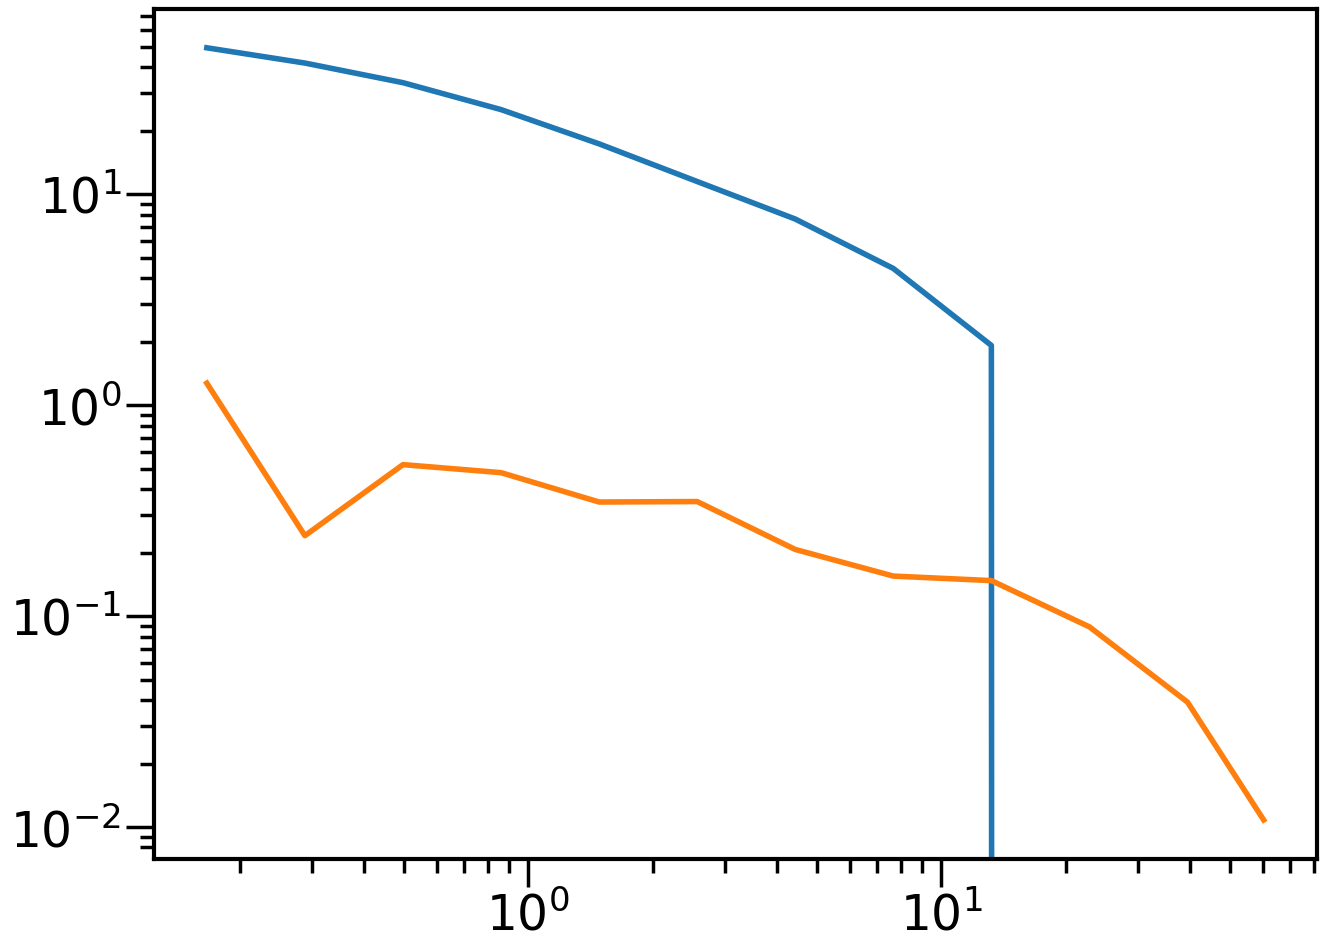

In [139]:
plot(rp,CI[fn]['wgg_jk'].mean(axis=0))
plot(rp,CI[fn]['data_jk'].mean(axis=0))
loglog()

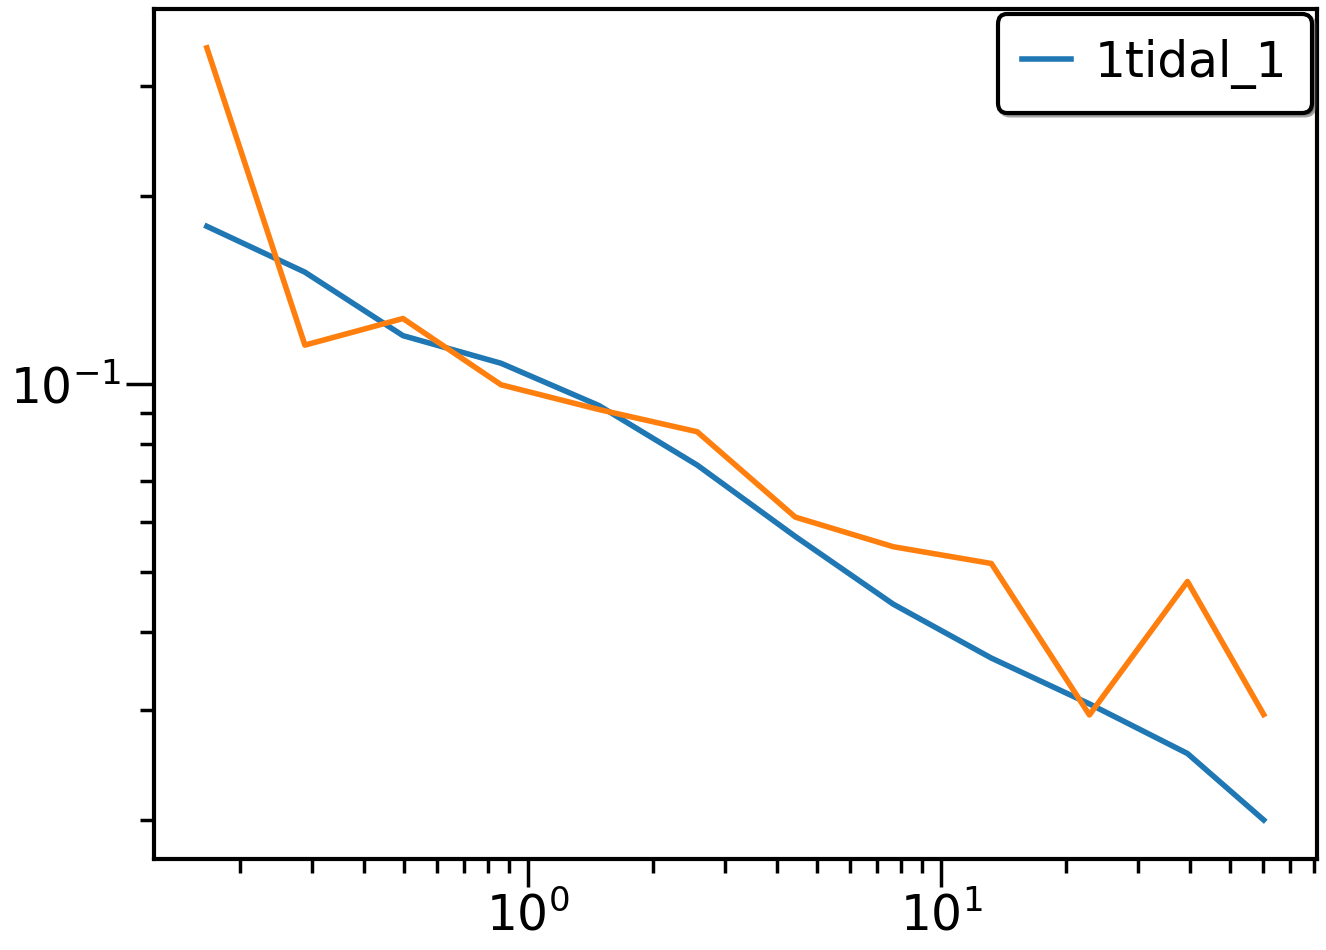

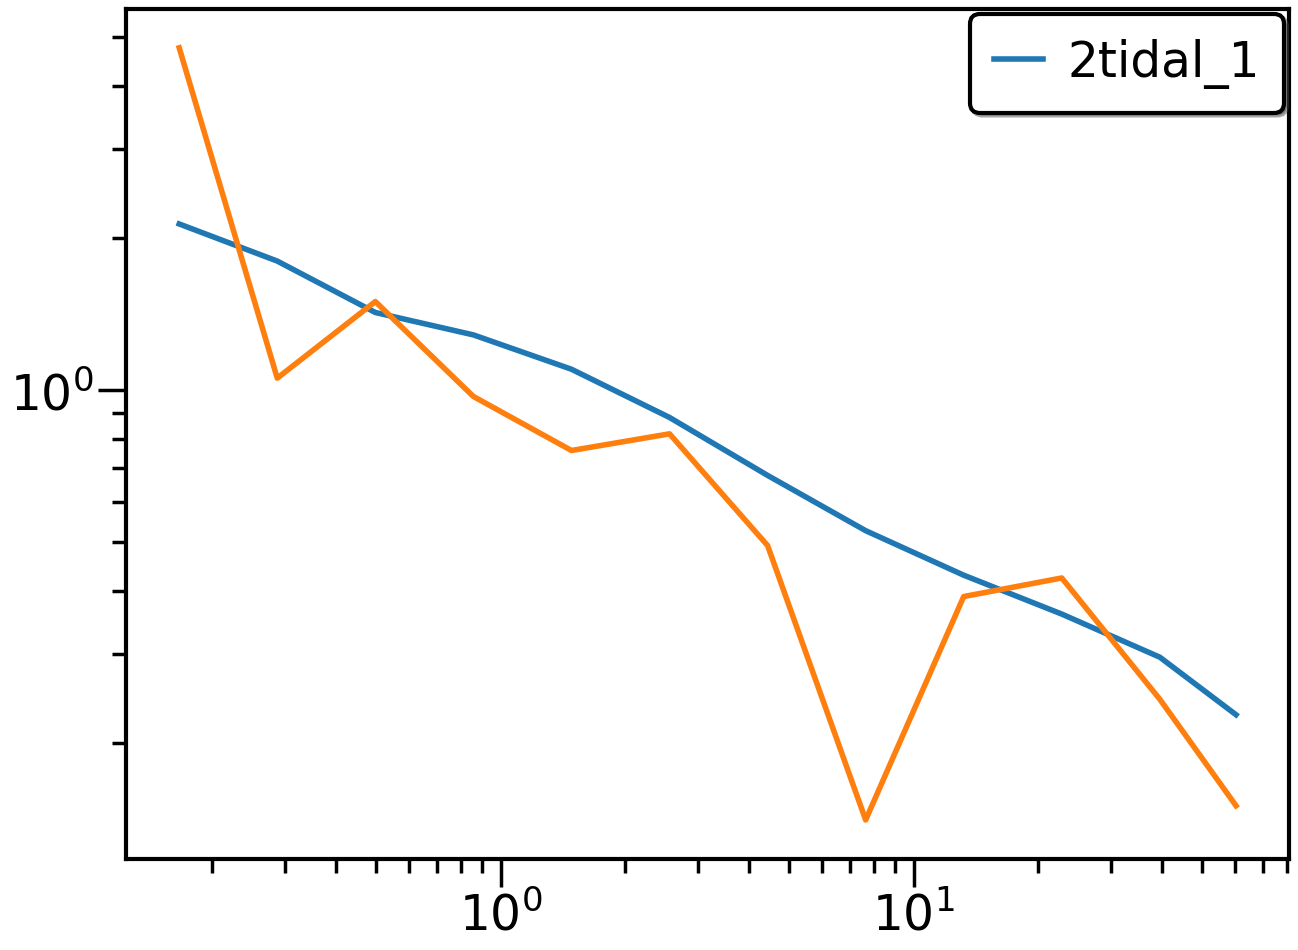

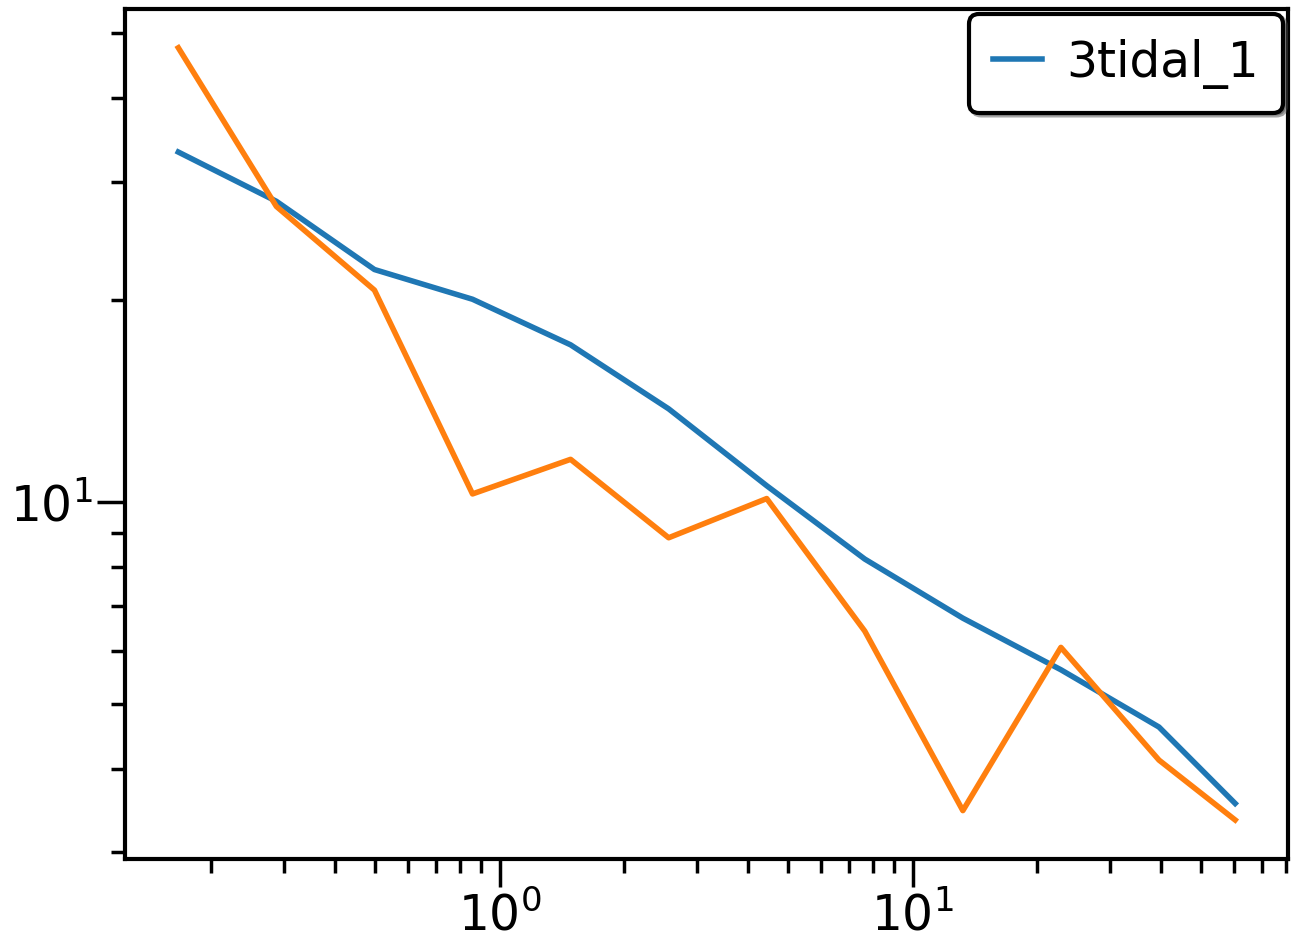

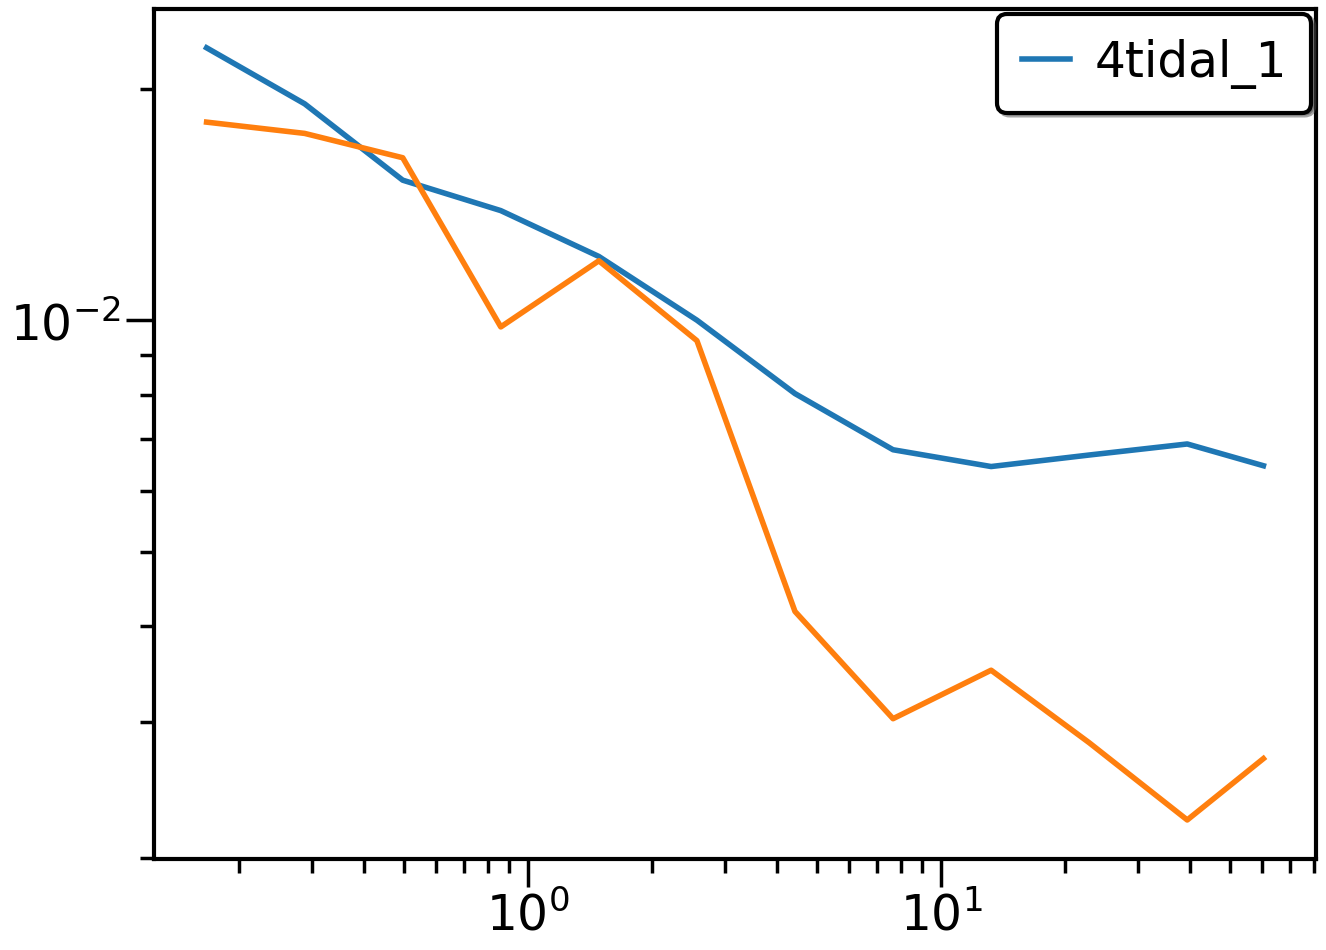

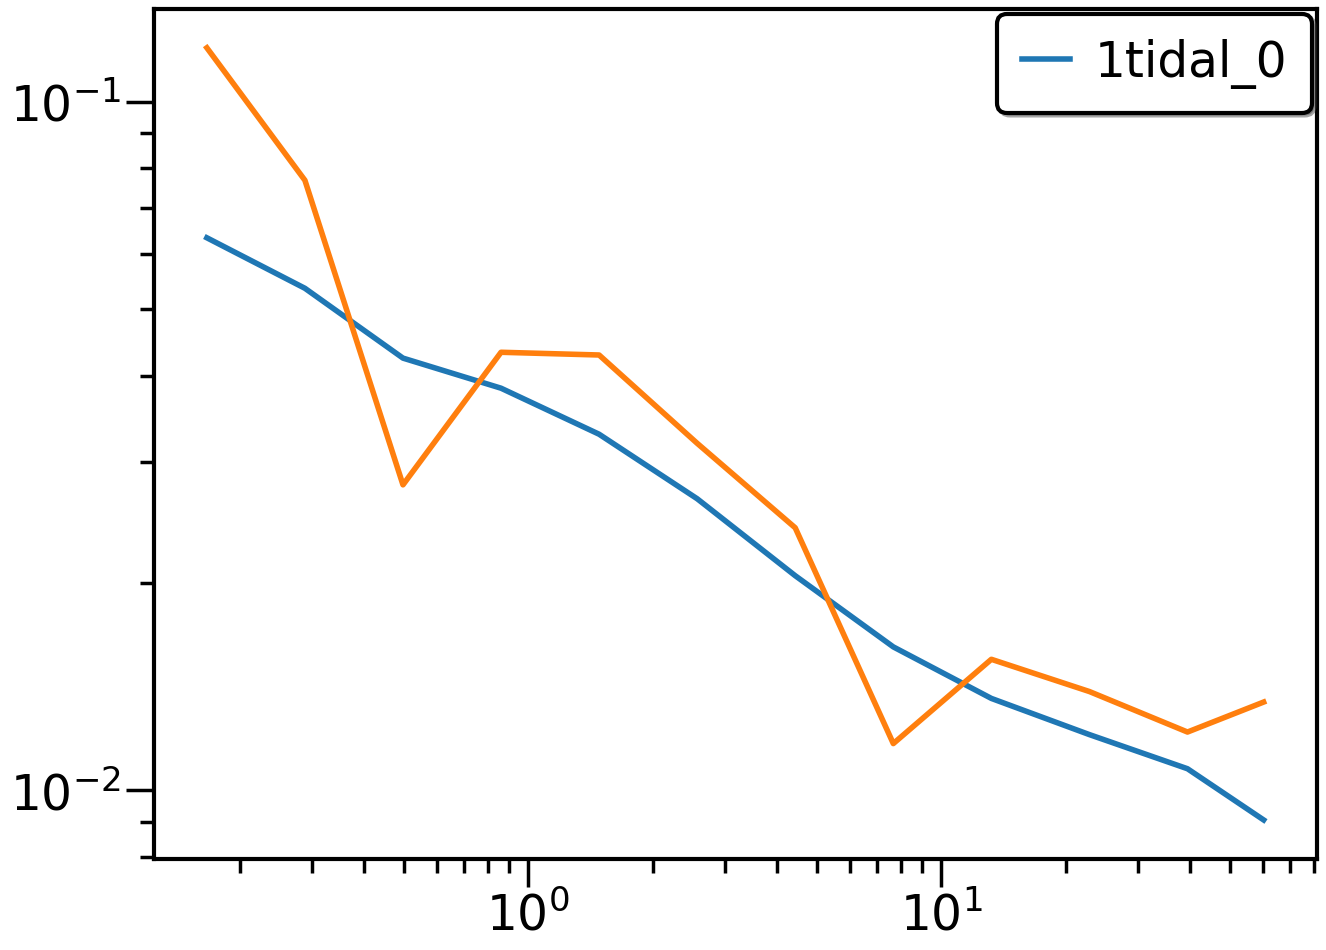

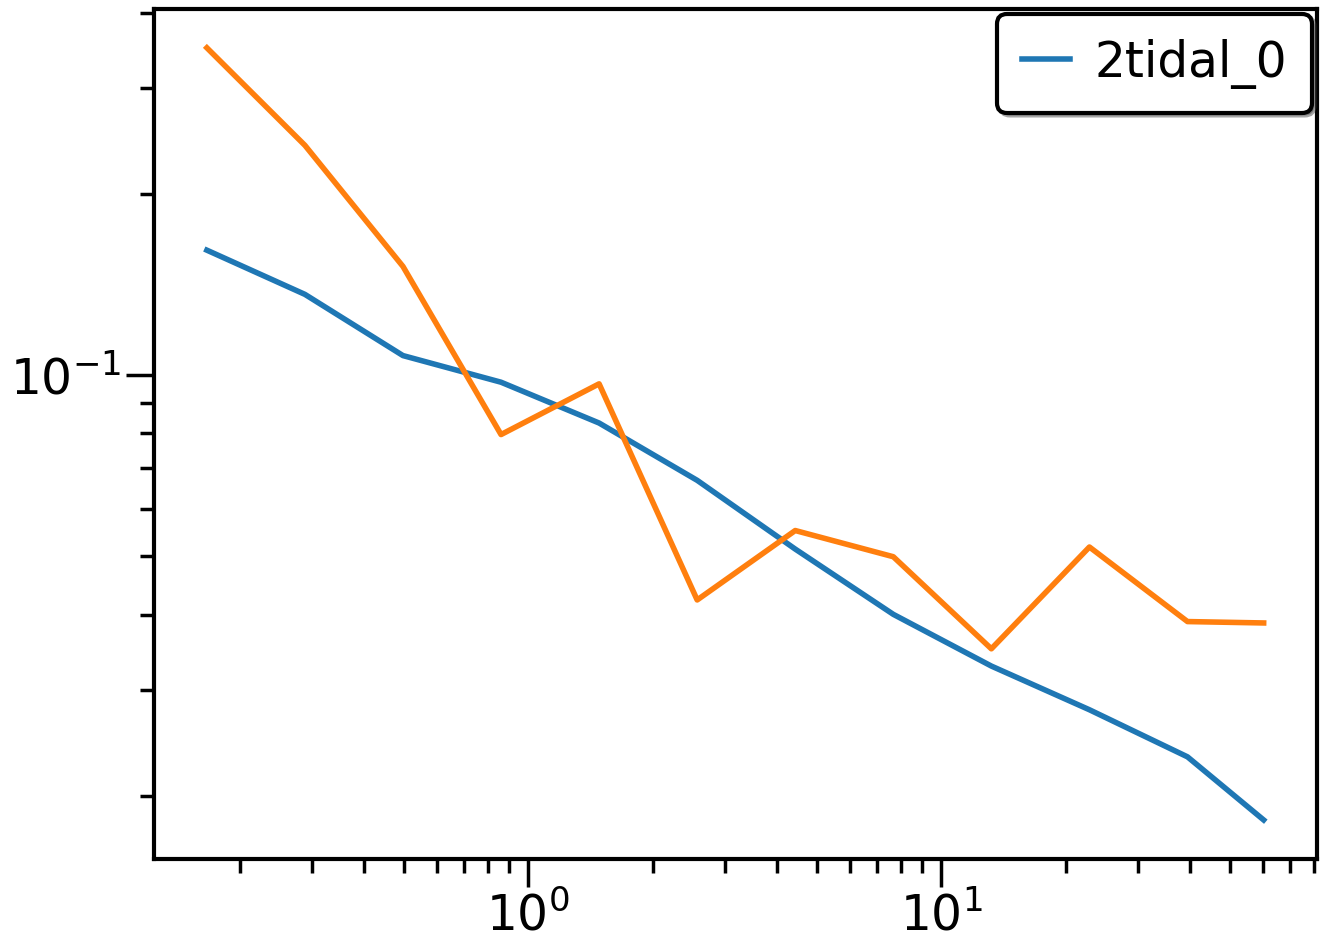

KeyError: '3tidal_0'

In [131]:
for fn in fns:
    rp=CI[fn]['rp']
    plot(CI[fn]['rp'],CI[fn]['err_ana'],label=fn)
    plot(CI[fn]['rp'],CI[fn]['err'])
    loglog()
    legend()
    show()

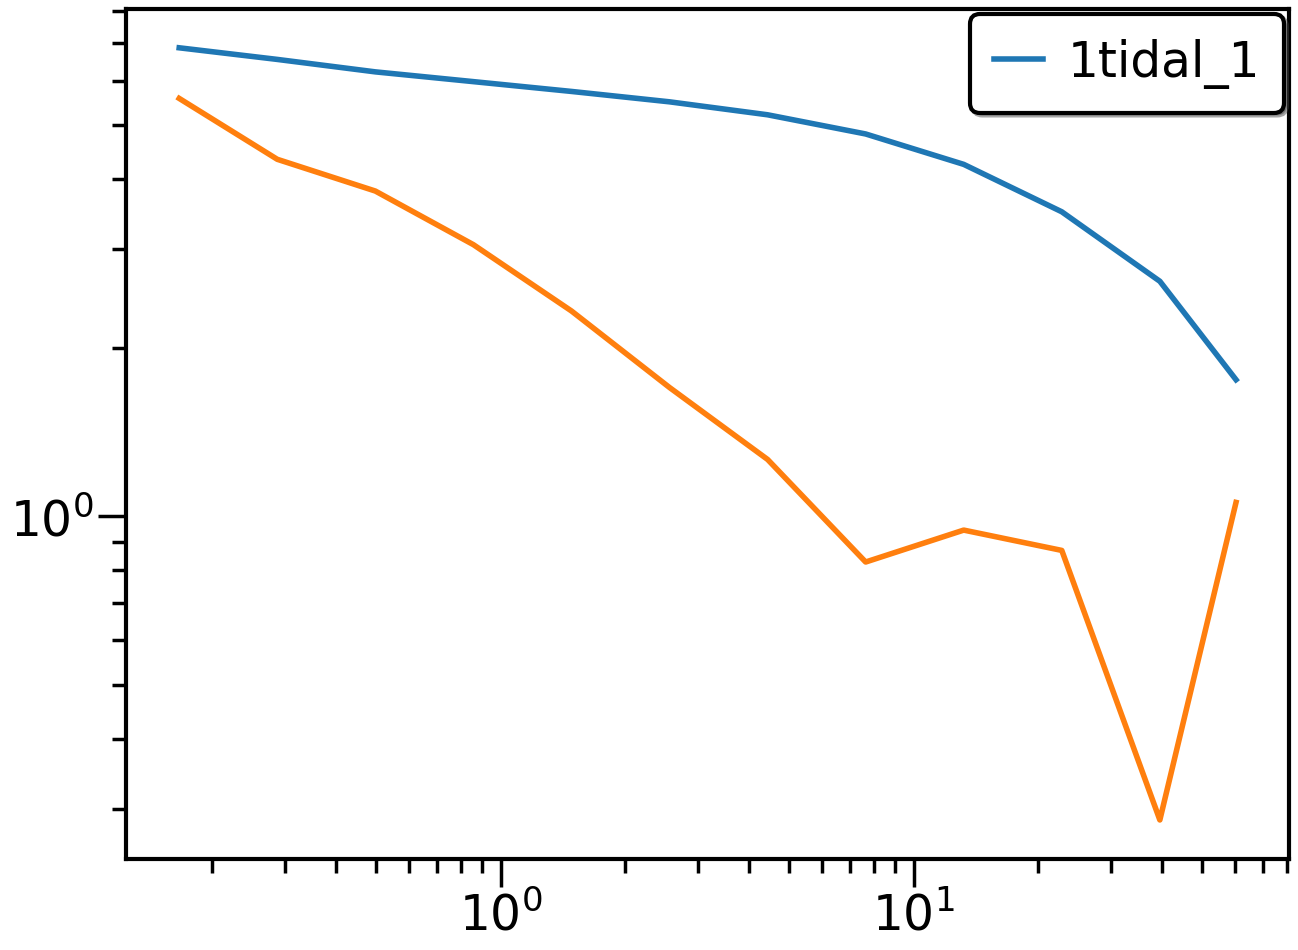

In [132]:
for fn in fns[:1]:
    rp=CI[fn]['rp']
    plot(CI[fn]['rp'],CI[fn]['err_gg_ana'],label=fn)
    plot(CI[fn]['rp'],CI[fn]['err_gg'])
    loglog()
    legend()
    show()

In [ ]:
for fn in fns:
    pcolor(rp,rp,CI[fn]['corr'],vmin=-1,vmax=1,cmap='seismic')
    loglog()
    title(fn)
    show()
    pcolor(rp,rp,CI[fn]['corr_ana'],vmin=-1,vmax=1,cmap='seismic')
    loglog()
    title(fn+' ana')
    show()

In [ ]:
for fn in fns:
    pcolor(rp,rp,CI[fn]['corr'],vmin=-1,vmax=1,cmap='seismic')
    loglog()
    title(fn)
    show()
    pcolor(rp,rp,CI[fn]['corr_ana'],vmin=-1,vmax=1,cmap='seismic')
    loglog()
    title(fn+' ana')
    show()